In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import time


In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()

for step in range(200):
    env.render()
    action = env.action_space.sample() #0 or 1
    observation, reward, terminated, truncated, info = env.step(action)
    time.sleep(0.01)
    
env.close()

/Users/tylergasperlin/opt/anaconda3/lib/python3.9/site-packages/gymnasium/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [3]:
observation
# cartposition, cart velocity, angle, angle velocity

array([ 1.9755156 ,  0.87715393, 14.540969  ,  7.964362  ], dtype=float32)

In [4]:
def create_bins(num_bins_per_obs=10):
    bins_cart_position = np.linspace(-4.8,4.8,num_bins_per_obs)
    bins_cart_velocity = np.linspace(-5,5, num_bins_per_obs)
    bins_pole_angle = np.linspace(-0.418,0.418,num_bins_per_obs)
    bins_pole_angular_velocity = np.linspace(-5,5, num_bins_per_obs)
    bins = np.array([bins_cart_position,
                     bins_cart_velocity,
                     bins_cart_velocity, 
                     bins_pole_angular_velocity])
    return bins

In [5]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)

In [6]:
demo_bin = [0,2,4,6,8,10]
demo_data = 9
np.digitize(demo_data,demo_bin)

5

In [7]:
def discretize_observation(observations,bins):

    binned_observations = []

    for i,observation in enumerate(observations):
        discretize_observation = np.digitize(observation,bins[i])
        binned_observations.append(discretize_observation)
    
    return tuple(binned_observations)


In [8]:
observations = env.reset()[0]

In [9]:
mapped_observation = discretize_observation(observations, BINS )

In [10]:
mapped_observation

(5, 5, 5, 5)

In [11]:
q_table_shape = (NUM_BINS, NUM_BINS,NUM_BINS,NUM_BINS,env.action_space.n)

In [12]:
q_table = np.zeros(q_table_shape)

In [13]:
#q_table
q_table.shape # a 4 dimensional table

(10, 10, 10, 10, 2)

In [14]:
def epsilon_greedy_action_selection(epsilon, q_table,discrete_state):
    
    random_number = np.random.random()
    
    #exploitation - choose thea action that maximizes q
    if random_number > epsilon:
        state_row = q_table[discrete_state,:] # return a row from q
        action = np.argmax(state_row) #actions are 0,1,2,3
    # exploration - choose a random action 
    else:
        action = env.action_space.sample()
        
    return action

In [15]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value, ALPHA, GAMMA):
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)


In [16]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9

In [17]:
epsilon = 1.0
BURN_IN = 1
EPSILON_END= 10000
EPSILON_REDUCE = 0.0001

In [18]:
def reduce_epsilon(epsilon,epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
    return epsilon

In [19]:
def fail(done,points,reward):
    if done and points < 150:
        reward = -200
        
    ## angular velocity +/- ##
    return reward 

0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
False
0
True
1
False
1
False
1
False
1
False
1
False
1
False
1
False
1
False
1
False
1
False
1
False
1
False
1
False
1
True
2
False
2
False
2
False
2
False
2
False
2
False
2
False
2
False
2
False
2
False
2
False
2
False
2
False
2
True
3
False
3
False
3
False
3
False
3
False
3
False
3
False
3
False
3
False
3
False
3
False
3
False
3
True
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
False
4
True
5
False
5
False
5
False
5
False
5
False
5
False
5
False
5
False
5
False
5
False
5
False
5
True
6
False
6
False
6
False
6
False
6
False
6
False
6
False
6
False
6
False
6
False
6
False
6
False
6
False
6
True
7
False
7
False
7
False
7
False
7
False
7
False
7
False
7
False
7
False
7
False
7
False
7
False
7
True
8
False
8
False
8
False
8
False
8
False
8
False
8
False
8
False
8
False


AssertionError: 1111 (<class 'numpy.int64'>) invalid

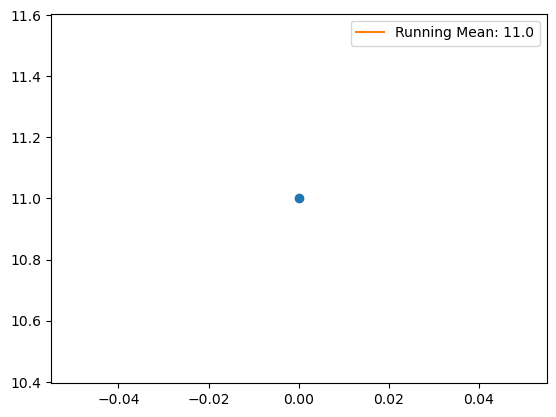

In [20]:
## visualization
log_interval = 500
render_interval = 30000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

points_log = []
mean_points_log = []
epochs = []

for epoch in range(EPOCHS):
    initial_state = env.reset()[0]
    discretized_state = discretize_observation(initial_state, BINS)
    
    done = False
    points = 0
    
    epochs.append(epoch)
    
    #####play game######
    while not done:
        action = epsilon_greedy_action_selection(epsilon,q_table,discretized_state)
        print(epoch)
        next_state,reward,done,truncated,info = env.step(action)
        print(done)
        reward = fail(done,points,reward)
        
        next_state_discretized = discretize_observation(next_state,BINS)
        
        old_q_value = q_table[discretized_state+(action,)]  
        next_optimal_q_value = np.max(q_table[next_state_discretized])
        
        next_q = compute_next_q_value(old_q_value,reward,next_optimal_q_value, ALPHA, GAMMA)
        q_table[discretized_state+(action,)] = next_q
        
        discretized_state = next_state_discretized
        points += 1
        
    epsilon = reduce_epsilon(epsilon,epoch)
    points_log.append(points)
    running_mean = round(np.mean(points_log[-30:]),2)
    mean_points_log.append(running_mean)
    
    ##
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs,points_log)
        ax.plot(epochs,points_log)
        ax.plot(epochs,mean_points_log,label=f'Running Mean: {running_mean}')
        plt.legend()
        fig.canvas.draw()
        
env.close()